In [11]:
import sys
import xarray as xr
import pandas as pd
from pathlib import Path
from pyswmm import Simulation, Nodes, Output, SimulationPreConfig
from pyswmm import Simulation, Nodes, Links, Subcatchments, SystemStats, Simulation

sys.path.append(r'C:\Users\everett\Documents\GitHub\camus_to')


data_file = r"C:\Users\everett\Documents\GitHub\camus_to\data\clean\camus_to.nc"

from swmmio import Model

In [ ]:


model_dir = Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm")
station_ids = [f.stem for f in model_dir.iterdir()]

for station_id in station_ids[:2]:
    model_file = model_dir / station_id / f"{station_id}.inp"

    model_dir = Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm")
    model_file = model_dir / station_id / f"{station_id}.inp"

    forcings_df = pd.read_pickle(model_dir / station_id / "forcings.pkl")
    targets_df = pd.read_pickle(model_dir / station_id / "targets.pkl")
    # Copy the model file to a new location


In [150]:
import pandas as pd
mdl = Model(str(model_file))
mdl.inp.files

rff_file = "precipitation.rff"
new_file_entry = pd.DataFrame([{"Action": "SAVE", "FileType": "RAINFALL", "FileName": f"{rff_file}"}])
mdl.inp.files = pd.concat([mdl.inp.files, new_file_entry], ignore_index=True)
mdl.inp.save()

with Simulation(str(model_file)) as sim:
    sim.execute()
    sim.close()

mdl = Model(str(model_file))
mdl.inp.files = mdl.inp.files.assign(Action="USE")
mdl.inp.save()

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\everett\\Documents\\GitHub\\camus_to\\data\\models\\swmm\\HY035\\HY035.inp'

In [37]:
mdl = Model(str(model_file))
mdl.inp.files = mdl.inp.files.assign(Action="USE")
mdl.inp.save()
mdl = Model(str(model_file))
mdl.inp.files


,Action,FileType,FileName
0,USE,HOTSTART,hotstart.hsf
1,USE,RAINFALL,precipitation.rff
2,USE,RAINFALL,precipitation.rff
3,USE,RAINFALL,precipitation.rff
4,USE,RAINFALL,precipitation.rff


In [38]:
with Simulation(str(model_file)) as sim:
    sim.execute()


... SWMM Version 5.2.4
... Run Complete

In [10]:
from utils.calparams import CalParam, CalParams

cps = CalParams()
cps.append(CalParam(section='infiltration', attribute='CurveNum', lower=0.9, upper=0.9, lower_limit=0, upper_limit=100, distributed=True))
#cps.append(CalParam(section='subcatchments', attribute='PercImperv', lower=1, upper=1, lower_limit=0, upper_limit=100, distributed=True))
#cps.append(CalParam(section='subcatchments', attribute='Width', lower=0.5, upper=0.5, lower_limit=0.1, upper_limit=10**6, distributed=True))
#cps.append(CalParam(section='subcatchments', attribute='Area', lower=1, upper=2, lower_limit=0, upper_limit=1E6, distributed=True))
#cps.append(CalParam(section='xsections', attribute='Geom1', lower=1, upper=2, lower_limit=0, upper_limit=1E6, distributed=True))
#cps.append(CalParam(section='conduits', attribute='Roughness', lower=1, upper=2, lower_limit=0, upper_limit=1E6, distributed=True))

cps = cps.distribute(model=Model(str(model_file)))
cps.set_relative_bounds()

[c.lower for c in cps]

[np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998),
 np.float64(9.499999999999998)]

<Axes: >

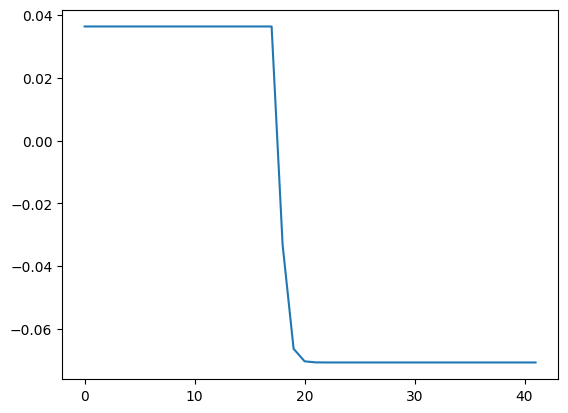

In [60]:
import pandas as pd
run_folder = Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY024\runs")
subfolders = [f.name for f in run_folder.iterdir() if f.is_dir()]

run_dir = run_folder / subfolders[-1]
scores_file = run_dir / "results_scores.txt"
scores_df = pd.read_csv(scores_file, sep=",", header=0)  # Adjust the separator if necessary


param_file = run_dir / "results_params.txt"
params_df = pd.read_csv(param_file, sep=",")  # Adjust the separator if necessary

import matplotlib.pyplot as plt

scores_df.columns

Index(['datetime', 'iter', 'obj_param', 'node', ' fun', ' score'], dtype='object')

In [ ]:
params_df[]

datetime        iter  obj_param        node  \
31/03/25 09:52:12 0     infiltration    CurveNum        NaN   95.000000   
                  0    subcatchments  PercImperv        NaN   13.171744   
                  0    subcatchments        Area        NaN  239.166667   
                  0    subcatchments       Width        NaN   13.652072   
31/03/25 09:52:20 5     infiltration    CurveNum        NaN   95.000000   
...                              ...         ...        ...         ...   
31/03/25 09:55:16 115  subcatchments       Width        NaN   13.652072   
31/03/25 09:55:24 120   infiltration    CurveNum        NaN   95.000000   
                  120  subcatchments  PercImperv        NaN   13.171744   
                  120  subcatchments        Area        NaN  239.166667   
                  120  subcatchments       Width        NaN   13.652072   

                            score  
31/03/25 09:52:12 0     92.858841  
                  0     16.883719  
                  0    656.944118  
                  0     31.061762  
31/03/25 09:52:20 5     60.995402  
...                           ...  
31/03/25 09:55:16 115   15.607488  
31/03/25 09:55:24 120   84.121981  
                  120   22.132248  
                  120  558.532509  
                  120    6.123913  

[100 rows x 5 columns]

In [1131]:
# Ensure obs and sim have the same index and column structure
obs_values = obs["discharge(cms)"].values
sim_values = sim["discharge(cms)"].values

# Calculate the mean of observed values
obs_mean = obs_values.mean()

# Calculate the numerator and denominator for NSE
numerator = ((obs_values - sim_values) ** 2).sum()
denominator = ((obs_values - obs_mean) ** 2).sum()

# Calculate NSE
nse = 1 - (numerator / denominator)
print(f"Nash-Sutcliffe Efficiency (NSE): {nse}")

Nash-Sutcliffe Efficiency (NSE): 0.3479649932115244


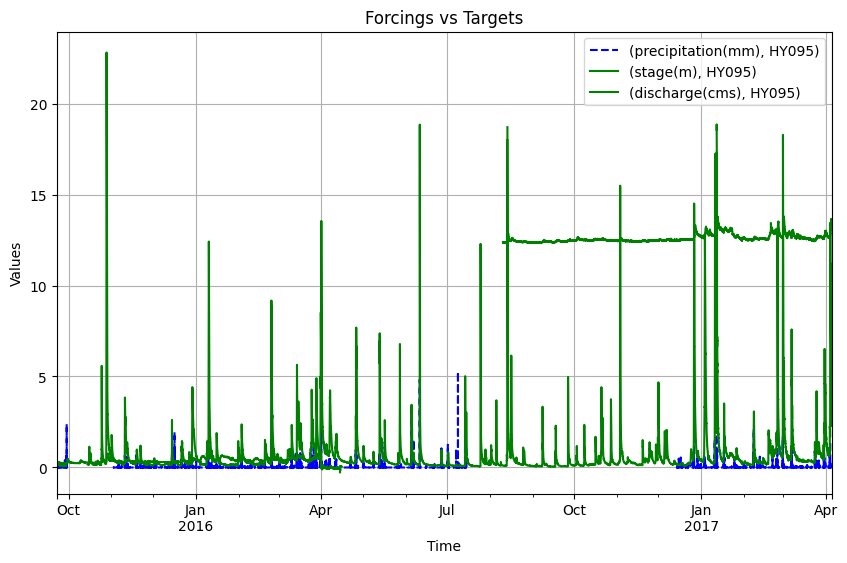

In [1142]:
import pandas as pd

# Read the pickle file
forcings_df = pd.read_pickle(model_dir / station_id / "forcings.pkl")
targets_df = pd.read_pickle(model_dir / station_id / "targets.pkl")

fig, ax = plt.subplots(figsize=(10, 6))

# Plot forcings
forcings_df.plot(ax=ax, label="Forcings", color="blue", linestyle="--")

# Plot targets
targets_df.plot(ax=ax, label="Targets", color="green")

# Add labels, legend, and grid
ax.set_title("Forcings vs Targets")
ax.set_xlabel("Time")
ax.set_ylabel("Values")
ax.legend()
ax.grid()
plt.show()

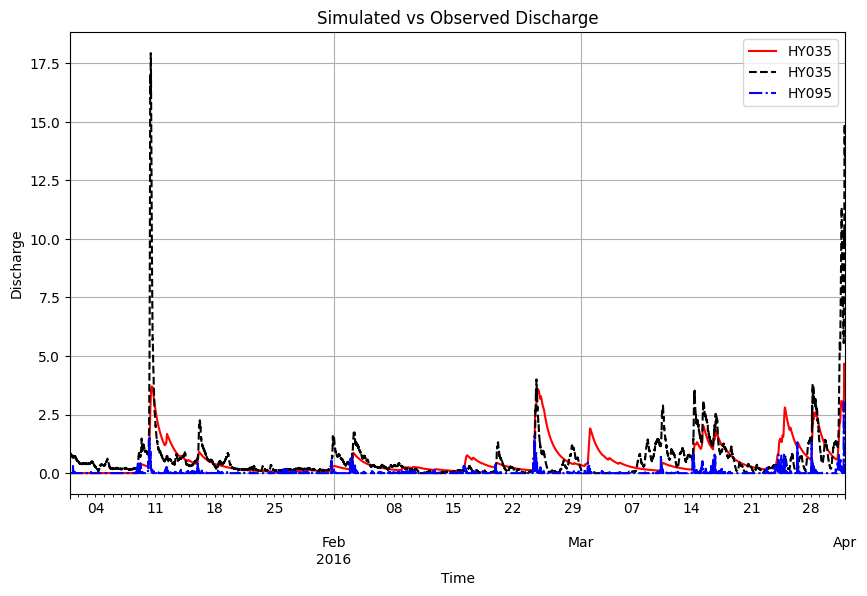

In [1132]:
iter = 100

sim = pd.read_pickle(run_dir / "timeseries" / f"sim_{iter}.pkl")
obs = pd.read_pickle(run_dir / "timeseries" / f"obs_{iter}.pkl")
precip = pd.read_pickle(model_dir / station_id / "forcings.pkl").loc[:,"precipitation(mm)"]


fig, ax = plt.subplots(figsize=(10, 6))
sim["discharge(cms)"].plot(ax=ax, label="Simulated Discharge (HY095)", color="red")
obs["discharge(cms)"].plot(ax=ax, label="Observed Discharge (HY095)", color="black", linestyle="--")
precip.plot(ax=ax, label="Precipitation", color="blue", linestyle="-.")

plt.legend()
plt.title("Simulated vs Observed Discharge")
plt.xlabel("Time")
plt.ylabel("Discharge")
plt.grid()
ax.set_xlim(obs.index.min(), obs.index.max())
plt.show()

C:\Users\everett\AppData\Local\Temp\ipykernel_18188\1130246203.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(subdirs))
c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\swmmio\utils\dataframes.py:135: UserWarning: VERTICES section not found in C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY006\HY006.inp
  warnings.warn(f'{sect} section not found in {inp_path}')
c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\swmmio\utils\dataframes.py:135: UserWarning: VERTICES section not found in C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY010\HY010.inp
  warnings.warn(f'{sect} section not found in {inp_path}')
c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\swmmio\utils\dataframes.py:135: UserWarning:

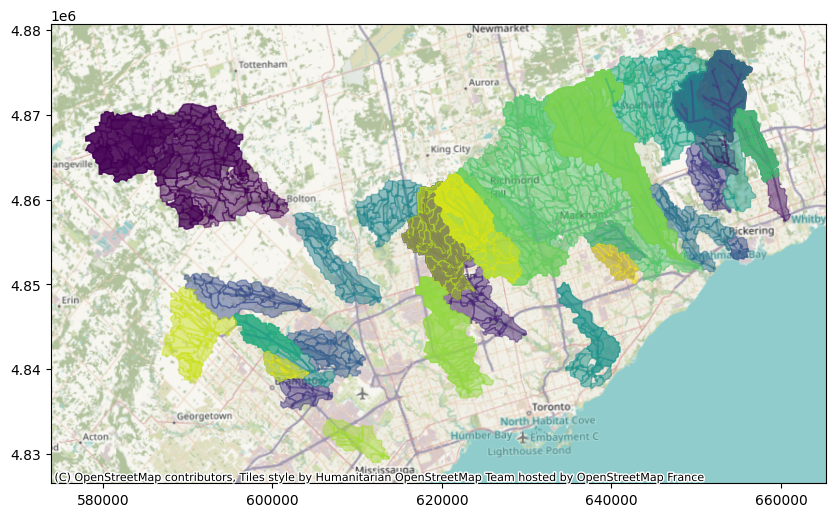

In [51]:
import contextily as ctx


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

model_dir = Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm")
subdirs = [f for f in model_dir.iterdir() if f.is_dir()]
import matplotlib.cm as cm
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=0, vmax=len(subdirs))
cmap = cm.get_cmap('viridis', len(subdirs))

for ii, subdir in enumerate(subdirs):
    mdl = Model(str(subdir / f"{subdir.name}.inp"), crs="epsg:26917")
    mdl.subcatchments.geodataframe.plot(ax=ax, label=subdir.name, edgecolor=cmap(norm(ii)), alpha=0.5, facecolor=cmap(norm(ii)))
    mdl.nodes.geodataframe.plot(ax=ax, label=subdir.name, edgecolor=cmap(norm(ii)), alpha=0.5, facecolor=cmap(norm(ii)), markersize=3)
    mdl.links.geodataframe.plot(ax=ax, label=subdir.name, edgecolor=cmap(norm(ii)), alpha=0.5, facecolor=cmap(norm(ii)))
ctx.add_basemap(ax, crs="epsg:26917")

In [ ]:
from utils.calparams import CalParam

cps = list()
cps.append(CalParam(section='infiltration', attribute='CurveNum', lower=1, upper=1, lower_bound=0, upper_bound=100, distributed=True))
cps.append(CalParam(section='subcatchments', attribute='Width', lower=0.5, upper=0.5, lower_bound=0.1, upper_bound=10**6, distributed=True))
#cps.append(CalParam(section='subcatchments', attribute='PercSlope', lower=1, upper=1, lower_bound=0, upper_bound=100, distributed=True))
cps.append(CalParam(section='subcatchments', attribute='Area', lower=1, upper=0, lower_bound=0, upper_bound=1E6, distributed=True))

from swmmio import Model
cps_distributed = []
for cp in cps:
    cps_distributed += cp.distribute(Model(str(model_file)))

# update the bounds relative to the initial values of each calibration parameter
cps_distributed = [cp.set_relative_bounds(upper=cp.upper, lower=cp.lower) for cp in cps_distributed]




HY035.rpt failed to initialize
negative seek position -168
HY035.rpt failed to initialize
negative seek position -168
HY035.rpt failed to initialize
negative seek position -168


In [4]:
with Simulation(str(model_file), outputfile="test.out") as sim:
    S1 = Subcatchments(sim)["s1"]
    print(S1.area)
    sim.execute()

from pyswmm import Output
from swmm.toolkit import shared_enum

with Output("test.out") as out:
    ok = out.node_series("HY035", shared_enum.NodeAttribute.TOTAL_INFLOW)


print(ok)
shared_enum.NodeAttribute.TOTAL_INFLOW


1529.0

... SWMM Version 5.2.4
... Run Complete{datetime.datetime(2016, 2, 1, 0, 0): 0.06890132278203964}


<NodeAttribute.TOTAL_INFLOW: 4>

HY035.rpt failed to initialize
negative seek position -168


In [ ]:
with Simulation(str(model_file), outputfile="test.out") as sim:
    S1 = Subcatchments(sim)["s1"]
    print(S1)
    print(infiltration_params)

TypeError: 'PySWMM' object is not callable

In [ ]:
import os
spc = SimulationPreConfig()
spc.input_file = str(model_file)
spc.add_update_by_token("SUBCATCHMENTS", "s1", 3, 1321321000000)
spc.add_update_by_token("SUBCATCHMENTS", "s2", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s3", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s4", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s5", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s7", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s8", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s9", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s10", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s11", 3, 1321312000000)
spc.apply_changes()

with Simulation(str(model_file), sim_preconfig=spc, outputfile="test.out") as sim:
    S1 = Subcatchments(sim)["s1"]
    print(S1.area)
    sim.execute()

from pyswmm import Output
from swmm.toolkit import shared_enum

with Output("test.out") as out:
    ok = out.node_series("HY035", shared_enum.NodeAttribute.TOTAL_INFLOW)


print(ok)
shared_enum.NodeAttribute.TOTAL_INFLOW

from utils.swmmutils import get_model_path

os.remove("test.out")


1321321000000.0

... SWMM Version 5.2.4

KeyboardInterrupt: 

In [166]:
import pandas as pd
pd.DataFrame(index=ok.keys(), data=ok.values()).plot()

NameError: name 'ok' is not defined

In [ ]:
with Simulation(str(model_file), outputfile="test.out") as sim:
    subcatchment_ids = [s.subcatchmentid for s in Subcatchments(sim)]
    ok = Subcatchments(sim)["s1"].__getattribute__("width")

ok


AttributeError: 'Subcatchment' object has no attribute 's'

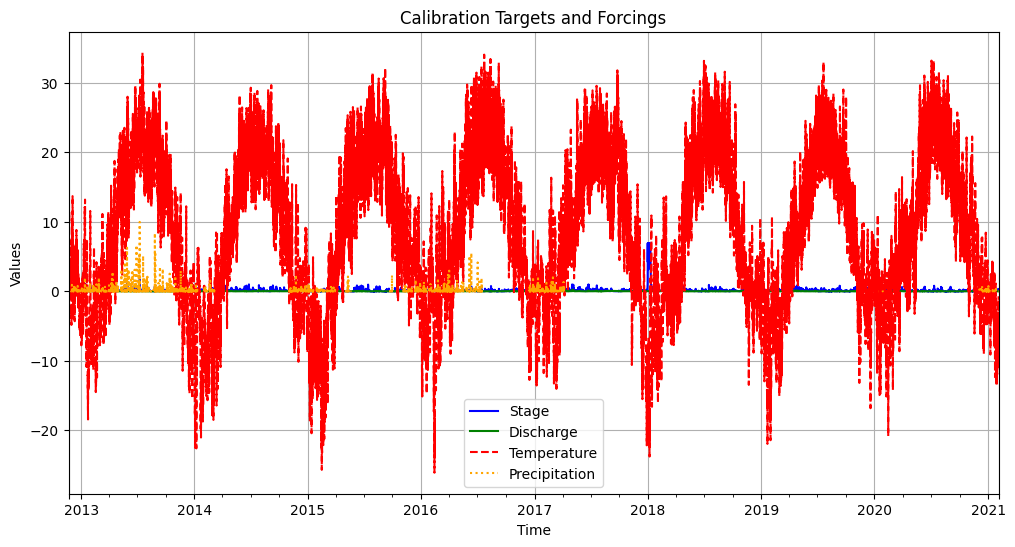

In [125]:
from utils.optconfig import OptConfig

oc = OptConfig(
    model_file = model_file,
    forcing_data_file = model_dir / station_id / "forcings.pkl",
    target_data_file = model_dir / station_id / "targets.pkl",
    run_folder = model_dir / station_id / "runs",
)

cal_targets = pd.read_pickle(oc.target_data_file)
cal_forcings = pd.read_pickle(oc.forcing_data_file)


fig, ax = plt.subplots(figsize=(12, 6))

# Plot cal_targets
cal_targets[("stage", station_id)].plot(ax=ax, label="Stage", color="blue")
cal_targets[("discharge", station_id)].plot(ax=ax, label="Discharge", color="green")

# Plot cal_forcings
cal_forcings[("temperature", station_id)].plot(ax=ax, label="Temperature", color="red", linestyle="--")
cal_forcings[("precipitation", station_id)].plot(ax=ax, label="Precipitation", color="orange", linestyle=":")

# Add labels, legend, and grid
ax.set_title("Calibration Targets and Forcings")
ax.set_xlabel("Time")
ax.set_ylabel("Values")
ax.legend()
ax.grid()
plt.show()


... SWMM Version 5.2.4
... Run Complete

In [ ]:
for ii in range(100):
    Output(str(model_file.with_suffix('.out'))).node_series("HY035", shared_enum.NodeAttribute.TOTAL_INFLOW)




... SWMM Version 5.2.4

Exception: 
  ERROR 307: cannot open binary results file.

<aenum 'NodeAttribute'>

AttributeError: 'WindowsPath' object has no attribute 'inp'

{datetime.datetime(2012, 1, 1, 0, 15): 0.0,
 datetime.datetime(2012, 1, 1, 0, 30): 0.0,
 datetime.datetime(2012, 1, 1, 0, 45): 0.0,
 datetime.datetime(2012, 1, 1, 1, 0): 0.0,
 datetime.datetime(2012, 1, 1, 1, 15): 0.0,
 datetime.datetime(2012, 1, 1, 1, 30): 0.0,
 datetime.datetime(2012, 1, 1, 1, 45): 0.0,
 datetime.datetime(2012, 1, 1, 2, 0): 0.0,
 datetime.datetime(2012, 1, 1, 2, 15): 0.0,
 datetime.datetime(2012, 1, 1, 2, 30): 0.0,
 datetime.datetime(2012, 1, 1, 2, 45): 0.0,
 datetime.datetime(2012, 1, 1, 3, 0): 0.0,
 datetime.datetime(2012, 1, 1, 3, 15): 0.0,
 datetime.datetime(2012, 1, 1, 3, 30): 0.0,
 datetime.datetime(2012, 1, 1, 3, 45): 0.0,
 datetime.datetime(2012, 1, 1, 4, 0): 0.0,
 datetime.datetime(2012, 1, 1, 4, 15): 0.0,
 datetime.datetime(2012, 1, 1, 4, 30): 0.0,
 datetime.datetime(2012, 1, 1, 4, 45): 0.0,
 datetime.datetime(2012, 1, 1, 5, 0): 0.0,
 datetime.datetime(2012, 1, 1, 5, 15): 0.0,
 datetime.datetime(2012, 1, 1, 5, 30): 0.0,
 datetime.datetime(2012, 1, 1, 5, 45)

In [ ]:
nodes = ["node1","node2"]
res = {node:[] for node in nodes}
dti = []

PARAM_MAPPING = {"discharge":"total_inflow","stage":"depth"}

with Simulation(str(model_file)) as sim:
    for step in sim:
        dti.append(sim.current_time)
        for node in nodes:
            res[node].append(getattr(Nodes(sim)[node],PARAM_MAPPING["discharge"]))



In [ ]:
from utils.calibutils import _validate_target_data
import pandas as pd
from swmmio import Model
tgt = pd.read_pickle(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY035\targets.pkl")
mdl = Model(str(model_file))

_validate_target_data(tgt, mdl)



True

'C:\\Users\\everett\\Documents\\GitHub\\camus_to\\data\\models\\swmm\\HY035\\targets.pkl'

In [ ]:
from swmmio import Model
mdl = Model(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY095\HY095.inp")

from defs import SWMM_DATETIME_FMT


from utils.swmmutils import get_model_datetimes




In [ ]:
import pandas as pd
from pathlib import Path

tgt_stations = tgt.columns.get_level_values('station').unique().to_list()





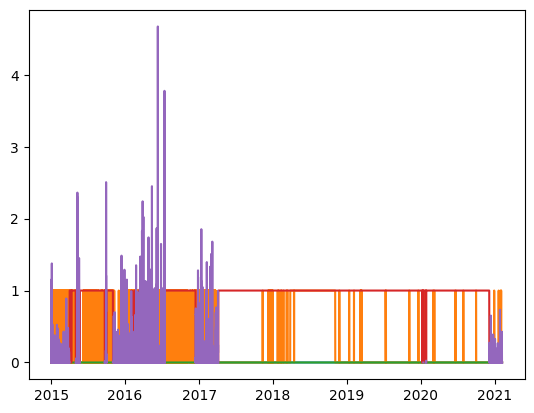

In [ ]:
plt.plot(df.isna())
plt.plot(df["precipitation"])

In [ ]:
import pandas as pd
df

,stage,discharge,temperature,precipitation
station,HY006,HY006,HY006,HY006
time,,,,
2015-01-01 00:15:00,0.252772,0.010861,-7.433333,0.000000
2015-01-01 00:30:00,0.254771,0.010996,-7.408333,0.000000
2015-01-01 00:45:00,0.256771,0.011030,-7.383333,0.000000
2015-01-01 01:00:00,0.259771,0.011064,-7.358333,0.000000
2015-01-01 01:15:00,0.261771,0.010928,-7.416667,0.095586
...,...,...,...,...
2021-02-05 18:00:00,0.275583,0.009178,-7.220000,0.000000
2021-02-05 18:15:00,0.275583,0.009114,-7.295000,0.000000
